<a href="https://colab.research.google.com/github/SaiGanesh26/Gender-Classification-Age-Estimation/blob/master/Gender_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import cv2
import numpy as np
import pandas as pd 
from google.colab import drive
from google.colab import files
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score
%matplotlib inline


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

In [3]:
# mount your drive to colab so that we can use the zip file present the google drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
wiki_process =  pd.read_csv("/content/drive/MyDrive/wiki_crop/wiki_process.csv")

In [5]:
wiki_process.head()

,gender,img_path,age
0,1.0,17/10000217_1981-05-05_2009.jpg,27
1,1.0,12/100012_1948-07-03_2008.jpg,59
2,0.0,16/10002116_1971-05-31_2012.jpg,40
3,0.0,02/10002702_1960-11-09_2012.jpg,51
4,1.0,41/10003541_1937-09-27_1971.jpg,33


In [6]:
count = 0
image_list = []
for path in wiki_process["img_path"]:
    if count == 500:
      break
    else:
      img = cv2.imread("/content/drive/MyDrive/wiki_crop/"+path,cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img,(350,350))
      image_list.append(img)
      count += 1

In [7]:
new_df = wiki_process.head(500)
len(new_df)

500

In [8]:
new_df["image"] = image_list
new_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,gender,img_path,age,image
0,1.0,17/10000217_1981-05-05_2009.jpg,27,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,1.0,12/100012_1948-07-03_2008.jpg,59,"[[96, 94, 91, 90, 92, 96, 97, 98, 99, 100, 98,..."
2,0.0,16/10002116_1971-05-31_2012.jpg,40,"[[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, ..."
3,0.0,02/10002702_1960-11-09_2012.jpg,51,"[[121, 121, 121, 121, 121, 121, 122, 122, 122,..."
4,1.0,41/10003541_1937-09-27_1971.jpg,33,"[[190, 196, 204, 203, 201, 197, 198, 201, 203,..."


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


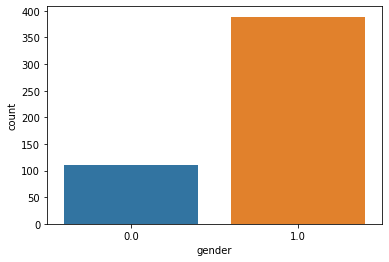

In [9]:
import seaborn as sns
sns.countplot(new_df["gender"])

In [10]:
new_df = new_df.dropna()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    500 non-null    float64
 1   img_path  500 non-null    object 
 2   age       500 non-null    int64  
 3   image     500 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 19.5+ KB


In [11]:
#normalizing the pixel values
x_data = np.array(image_list)/255
y_data = new_df["gender"].to_numpy()

In [12]:
# image_x will contain the original grayscale images 
x_data = x_data.reshape((x_data.shape[0],350,350,1))

print("x_data shape: {}".format(x_data.shape))
print("y_data shape: {}".format(y_data.shape))

x_data shape: (500, 350, 350, 1)
y_data shape: (500,)


In [13]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size = 0.1, random_state=42)

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}\n".format(train_y.shape))

print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

train_x shape: (450, 350, 350, 1)
train_y shape: (450,)

test_x shape: (50, 350, 350, 1)
test_y shape: (50,)


In [14]:
num_subjects = np.unique(y_data).shape[0]
print("Number of subjects: {}".format(np.unique(y_data).shape[0]))

Number of subjects: 2


In [15]:
# specify the input size of the images
images = Input((train_x.shape[1], train_x.shape[2], 1,))
# a convolution layer of 32 filters of size 9x9 to extract features (valid padding)
x = Conv2D(32,kernel_size=(15,15),padding="valid",strides=2)(images)
# a maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPool2D(pool_size=(2,2))(x)
#  # another convolution layer of 64 filters of size 11x11 to extract features (valid padding)
x = Conv2D(64,kernel_size=(15,15),padding="valid",strides=2)(x)
# # # a maxpooling layer to down-sample features with pool size (2, 2)
x = MaxPool2D(pool_size=(2,2))(x)
# flatten extracted features to form feature vector
x = Flatten()(x)
# a drop out layer for regularization (25% probability)
x = Dropout(rate=0.25,seed=0.25)(x)
# first fully-connected layer to map the features to vectors of size 256
x = Dense(64,activation="relu")(x)
# anoter drop out layer for regularization (25% probability)
x = Dropout(rate=0.25,seed=0.25)(x)
# a second fully-connected layer to map the features to a logit vector with one logit per subject
x = Dense(num_subjects)(x)
# use softmax activation to convert the logits to class probabilities for each subject
predictions = Activation("sigmoid")(x)

# create the model using the layers we defined previously
sample_cnn = Model(inputs=images, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
sample_cnn.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])

# print out a summary of the model achitecture
print(sample_cnn.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 350, 350, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 168, 168, 32)      7232      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 64)        460864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18496)            

In [ ]:
# train model
history = sample_cnn.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=5, verbose=1)

In [20]:
# evaluate model, get train/test accuracy
train_pred = np.argmax(sample_cnn.predict(train_x), axis=1)
test_pred = np.argmax(sample_cnn.predict(test_x), axis=1)
print("\nTraining accuracy using sample CNN model: {}".format(accuracy_score(train_y, train_pred)))
print("Testing accuracy using sample CNN model: {}\n".format(accuracy_score(test_y, test_pred)))


Training accuracy using sample CNN model: 0.2222222222222222
Testing accuracy using sample CNN model: 0.22



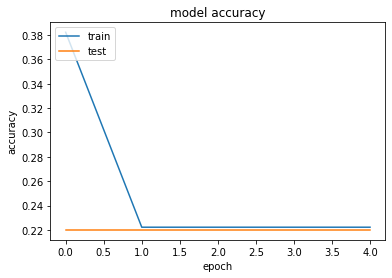

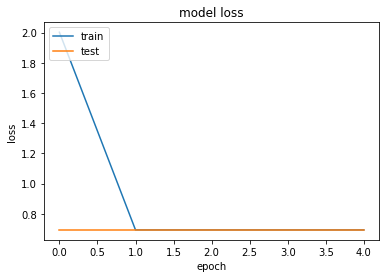

In [22]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()